# Identificador de Super-Heróis

- Nome: Eduardo Afonso Dutra Silva
- Matricula: 19/0012307

## Propósito

Este artigo tem como propósito demonstrar os passos seguidos para desenvolver um modelo de aprendizado de máquina capaz de identificar três diferentes diferentes 'super-heróis' cuja estética é bem similar. Os herois são Homelander (The Boys), Omniman (Invincible), Superman (DC Comics). Foi utilizado a plataforma `fastai` para desenvolver o modelo e a plataforma `huging face` para disponibilizar a solução neste [link](https://huggingface.co/spaces/oEduardoAfonso/hero_identifier).

## 1 - Buscando imagens

Começamos por criar uma função capaz de buscar links de imagens na plataforma DuckDuckGo baseando-se em um termo específico e uma quantidade máxima de imagens.

Foi definido um limite de 200 imagens por consulta, pois os três personagens são bastante conhecidos, havendo uma grande quantidade de conteúdo online.

In [1]:
!pip3 install -Uqq fastai duckduckgo_search

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.widgets import *

def search_images(term, max_images=200):
    print(f"Pesquisando por '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

O nome de cada personagem foi pesquisando acrescido da palavra `comics` para que o algoritmo trabalhasse apenas analisando imagens das versões das histórias em quadrinho visto que existem adapatações live action de alguns dos personagens.

As imagens foram salvas em pastas que contém o mesmo nome utilizado no termo de pesquisa que originou a imagem.

In [2]:
searches = 'homelander', 'omniman', 'superman'
path = Path('super_heroes')

from fastai.vision.all import *

for hero in searches:
    dest = (path/hero)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{hero} comics'))
    resize_images(path/hero, max_size=400, dest=path/hero)

Pesquisando por 'homelander comics'
Pesquisando por 'omniman comics'
Pesquisando por 'superman comics'


## 2 - Treinamento

Caso tenha ocorrido algum problema no download de alguma imagem o algoritmo poderia ser corrompido. Por este motivo foi utilizado a função a seguir para verificar a integridade das imagens e retira-las da amostra caso tenha havido algum erro.

In [3]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

30

As imagens selecionadas serão adicionadas a um `DataLoader`que fará a relação entre a imagem e a categoria em que ela se encontra (um dos três personagens). As imagens são separadas entre as que serão utilizadas para treinamento e as que serão utilizadas para validação (20%).

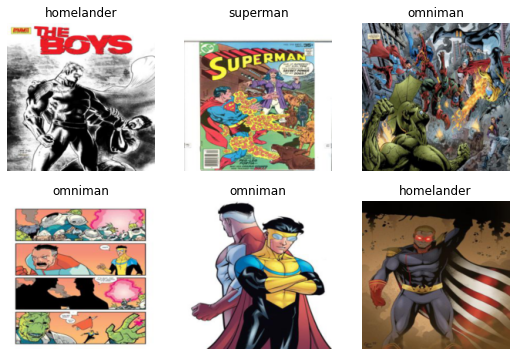

In [4]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

A quantidade de vezes que a função fine_tune é chamada, para aperfeiçoar o modelo baseado em outro modelo pré-treinado (resnet18), interfere na taxa de erro do modelo. Após três épocas a taxa de erro se mantinha constante e aceitável (3%), então essa foi a quantidade definida.

In [5]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.036246,0.160439,0.056701,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.170395,0.006400,0.000000,00:10
1,0.078749,0.001183,0.000000,00:11
2,0.044634,0.000767,0.000000,00:10


Foi então gerada uma matriz de confusão, onde é possível ver os casos em que o algortimo apresenta dificuldades em diferenciar as categorias. O resultado apresentado na matriz é bem agradável, nesta execução não houveram falhas, poreḿ, em algumas execuções há confusão entre os personagens `homelander:superman`.

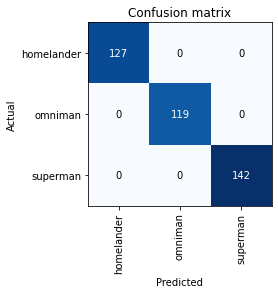

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

São então apresentados os piores resultados. Sendo esses quando o algoritmo tem altas confiança em uma predição errada, ou quanto tem baixa confiança em uma predição correta.

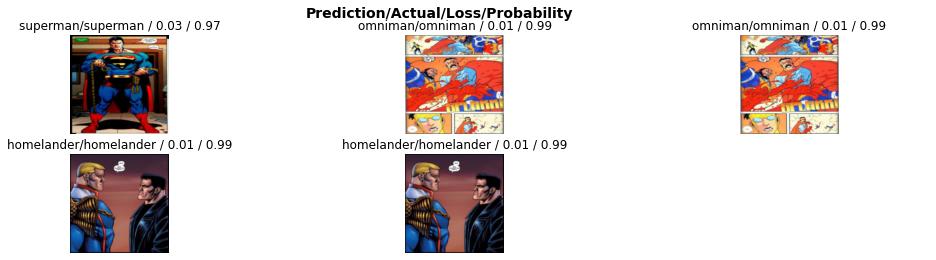

In [7]:
interp.plot_top_losses(5, nrows=2, figsize=(17,4))

Com a função de `cleaner` é possível remover as imagens que causaram confusão no algoritmo, assim melhorando sua precisão.

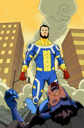

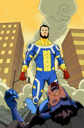

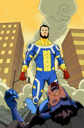

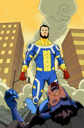

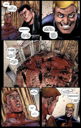

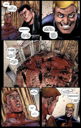

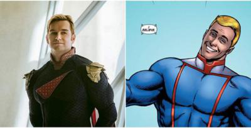

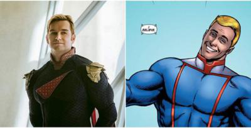

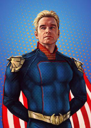

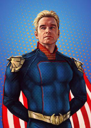

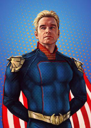

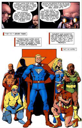

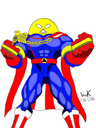

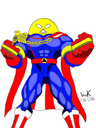

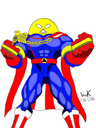

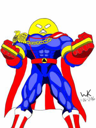

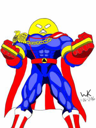

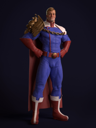

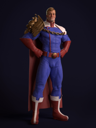

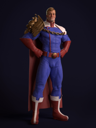

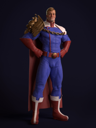

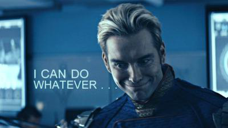

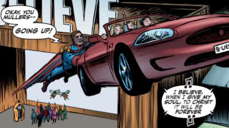

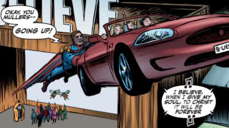

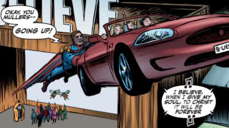

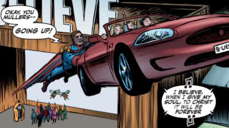

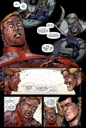

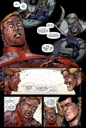

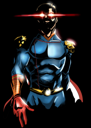

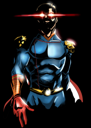

In [8]:
cleaner = ImageClassifierCleaner(learn)
cleaner

Os seguintes laços de repetição trocam de categoria as imagens marcadas anteriormente como categoria errada, e excluem as imagens que foram marcadas para serem removidas do DataLoader.

In [9]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

O modelo é então exportado para que seja possível fazer o deploy na plataforma [HuggingFace](https://huggingface.co/spaces/oEduardoAfonso/hero_identifier).

In [10]:
learn.export('model.pkl')

## 3 - Utilização

Iremos baixar uma imagem contendo uma arte não oficial (feita por fãs) para que possamos testar o algoritmo.

Pesquisando por 'omniman fanart'


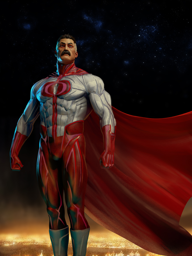

In [11]:
from fastdownload import download_url
dest = 'hero.jpg'
urls = search_images('omniman fanart', max_images=1)
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Passando a imagem que acabou de ser baixada para o algoritmo é possível fazer uma predição. Tendo como saída o palpite do algoritmo e a probabilidade de certeza que o algoritmo apresenta.

In [12]:
hero,_,probs = learn.predict(PILImage.create('hero.jpg'))
print(f"This is: {hero}.")
print(f"Probability it's {searches[0]}: {probs[0]:.4f}")
print(f"Probability it's {searches[1]}: {probs[1]:.4f}")
print(f"Probability it's {searches[2]}: {probs[2]:.4f}")

This is: omniman.
Probability it's homelander: 0.0000
Probability it's omniman: 1.0000
Probability it's superman: 0.0000


## Referências

[From Model to Production](https://github.com/fastai/fastbook/blob/master/02_production.ipynb). HOWARD, JEREMY. Kaggle's Jupyter Notebook.

[Practical Deep Learning for Coders 2022](https://course.fast.ai/). HOWARD, JEREMY. FASTAI.
